In [1]:
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,SimpleRNN,LSTM,GRU,Dropout,Concatenate
from keras.layers import LSTM
from keras.callbacks import TensorBoard
import time
import os
from keras.models import load_model

Using TensorFlow backend.


In [2]:
NAME1="LSTM-day-mae-adam{}".format(int(time.time()))
tensorboard=TensorBoard(log_dir='Miniproj2/{}'.format(NAME1))

In [3]:
data=np.load('polution_dataSet.npy')
days=int(data.shape[0]/24)
data_day=np.zeros([days,8])
for i in range(days):
    data_day[i,:]=data[i*24,:]
data_day.shape

(1824, 8)

In [4]:
# convert series to supervised learning
def series_to_supervised(data, n_in, n_out, dropnan=True):
    n_vars=data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        for j in range(n_vars):
            names += [('var%d(t-%d)' % (j+1, i))]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            for j in range(n_vars):
                names += [('var%d(t)' % (j+1))]
        else:
            for j in range(n_vars):
                names += [('var%d(t+%d)' % (j+1, i))]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [5]:
n_days=7
n_features=8
reframed = series_to_supervised(data_day, n_days,1)
reframed.shape

(1817, 64)

In [6]:
values = reframed.values
n_train_hours = 1276
n_validation_hours=182
n_test_hours=366

train = values[:n_train_hours, :]
validation=values[n_train_hours :n_train_hours+n_validation_hours,:]
test = values[n_train_hours+n_validation_hours:n_train_hours+n_validation_hours+n_test_hours, :]
# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
validation_X,validation_y=validation[:, :n_obs], validation[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
validation_X=validation_X.reshape((validation_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape,validation_X.shape, validation_y.shape, test_X.shape, test_y.shape)

(1276, 7, 8) (1276,) (182, 7, 8) (182,) (359, 7, 8) (359,)


Train on 1276 samples, validate on 182 samples
Epoch 1/50
 - 4s - loss: 0.0981 - val_loss: 0.0855
Epoch 2/50
 - 0s - loss: 0.0777 - val_loss: 0.0699
Epoch 3/50
 - 0s - loss: 0.0742 - val_loss: 0.0692
Epoch 4/50
 - 0s - loss: 0.0732 - val_loss: 0.0689
Epoch 5/50
 - 0s - loss: 0.0727 - val_loss: 0.0689
Epoch 6/50
 - 0s - loss: 0.0725 - val_loss: 0.0696
Epoch 7/50
 - 0s - loss: 0.0723 - val_loss: 0.0699
Epoch 8/50
 - 0s - loss: 0.0719 - val_loss: 0.0695
Epoch 9/50
 - 0s - loss: 0.0717 - val_loss: 0.0694
Epoch 10/50
 - 0s - loss: 0.0714 - val_loss: 0.0697
Epoch 11/50
 - 0s - loss: 0.0713 - val_loss: 0.0696
Epoch 12/50
 - 0s - loss: 0.0711 - val_loss: 0.0690
Epoch 13/50
 - 0s - loss: 0.0708 - val_loss: 0.0688
Epoch 14/50
 - 0s - loss: 0.0706 - val_loss: 0.0688
Epoch 15/50
 - 0s - loss: 0.0705 - val_loss: 0.0687
Epoch 16/50
 - 0s - loss: 0.0703 - val_loss: 0.0687
Epoch 17/50
 - 0s - loss: 0.0702 - val_loss: 0.0684
Epoch 18/50
 - 0s - loss: 0.0700 - val_loss: 0.0684
Epoch 19/50
 - 0s - loss: 

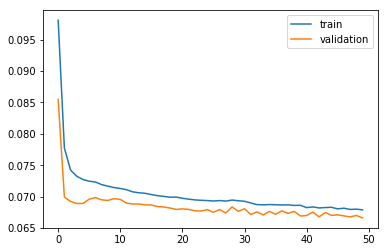

In [7]:
# design network
model = Sequential()
#model.add(SimpleRNN(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(Dropout(0.1))
model.add(Dense(1))
#model.add(Dropout(0.1))
model.compile(loss='mae', optimizer='adam')
# fit network
time1 = time.clock()
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(validation_X, validation_y), verbose=2, shuffle=False,callbacks=[tensorboard])
time2 = time.clock()
print("It took %d seconds to train"%(time2-time1))
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

In [8]:
test_predict = model.predict(test_X)
rmse = sqrt(mean_squared_error(test_y, test_predict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.097


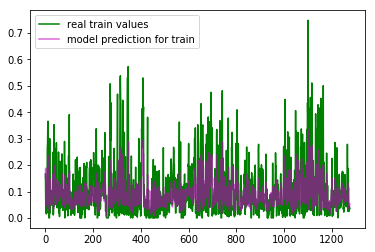

In [9]:
train_predict=model.predict(train_X)
pyplot.plot(train_y,'g', label='real train values')
pyplot.plot(train_predict, 'm', alpha=0.6, label='model prediction for train')
pyplot.legend()
pyplot.show()

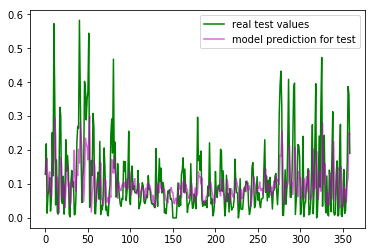

In [10]:
pyplot.plot(test_y,'g', label='real test values')
pyplot.plot(test_predict, 'm', alpha=0.6, label='model prediction for test')
pyplot.legend()
pyplot.show()